# Data Science Regression Project: Predicting Home Prices in USA

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)

## realtor-data.csv (2,226,382 entries)
- brokered by (categorically encoded agency/broker)
- status (Housing status - a. ready for sale or b. ready to build)
- price (Housing price, it is either the current listing price or recently sold - price if the house is sold recently)
- bed (# of beds)
- bath (# of bathrooms)
- acre_lot (Property / Land size in acres)
- street (categorically encoded street address)
- city (city name)
- state (state name)
- zip_code (postal code of the area)
- house_size (house area/size/living space in square feet)
- prev_sold_date (Previously sold date)

https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

In [4]:
df1 = pd.read_csv('realtor-data.csv')
df1.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [5]:
df1.shape

(2226382, 12)

## Drop unnecessary columns

In [7]:
# Limit the location to state for dimensionality reduction
df2 = df1.drop(['brokered_by', 'status', 'prev_sold_date', 'acre_lot', 'street', 'city', 'zip_code'], axis = 'columns')
df2.head()

,price,bed,bath,state,house_size
0,105000.0,3.0,2.0,Puerto Rico,920.0
1,80000.0,4.0,2.0,Puerto Rico,1527.0
2,67000.0,2.0,1.0,Puerto Rico,748.0
3,145000.0,4.0,2.0,Puerto Rico,1800.0
4,65000.0,6.0,2.0,Puerto Rico,NaN


## Data cleaning: NA values

In [9]:
df2.isnull().sum()

price           1541
bed           481317
bath          511771
state              8
house_size    568484
dtype: int64

In [10]:
# Not the best practice but for simplicity's sake
df3 = df2.dropna()
df3.isnull().sum()
df3 = df3[df3['price'] != 0]

In [11]:
df3.shape

(1605502, 5)

## Outlier Removal: Prices

In [13]:
# Function to remove price outliers per state by one std from mean
def remove_price_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('state'):
        m = np.mean(subdf.price)
        st = np.std(subdf.price)
        reduced_df = subdf[(subdf.price>(m-st)) & (subdf.price<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

In [14]:
df4 = remove_price_outliers(df3)
df4.shape

(1522753, 5)

## Feature Engineering

Add new feature called price_per_sqft

In [17]:
df4['price_per_sqft'] = df4['price']/df4['house_size']
df4.head()

,price,bed,bath,state,house_size,price_per_sqft
0,549000.0,4.0,4.0,Alabama,2919.0,188.078109
1,175000.0,3.0,2.0,Alabama,1234.0,141.815235
2,118500.0,3.0,1.0,Alabama,1276.0,92.868339
3,489900.0,3.0,3.0,Alabama,1840.0,266.250000
4,399900.0,4.0,3.0,Alabama,2709.0,147.619048


## Dimensionality Reduction

In [19]:
df4.state = df4.state.apply(lambda x: x.strip())

# Check number of states
print(df4['state'].nunique())

df4.groupby('state')['state'].agg('count')

54


state
Alabama                  19019
Alaska                     789
Arizona                  53674
Arkansas                 11528
California              189825
Colorado                 23251
Connecticut              11496
Delaware                  6259
District of Columbia      5630
Florida                 176372
Georgia                  51853
Guam                       251
Hawaii                    4730
Idaho                    11694
Illinois                 60140
Indiana                  12157
Iowa                     15650
Kansas                   10402
Kentucky                 16368
Louisiana                15638
Maine                     2264
Maryland                 37182
Massachusetts            33427
Michigan                 24260
Minnesota                32139
Mississippi               8243
Missouri                 30702
Montana                   5824
Nebraska                  4372
Nevada                   10624
New Hampshire             2217
New Jersey               22482
Ne

In [20]:
# There's only 50 U.S. states, so we want to group the rest into an "Other" category
# Use a list of the 50 U.S. states to filter out the rest
us_states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 
    'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 
    'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 
    'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 
    'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 
    'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 
    'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
]

In [21]:
df4.state = df4.state.apply(lambda x: 'Other' if x not in us_states else x)
len(df4.state.unique())

51

## Outlier Removal: Bedroom per Square Feet

In [23]:
df4['bed'].unique()

array([  4.,   3.,   2.,   5.,   1.,   6.,  11.,   7.,   8.,   9.,  12.,
        10.,  14.,  18.,  16.,  13.,  27.,  32.,  22.,  15.,  24.,  55.,
        37.,  20.,  30.,  19.,  17.,  26.,  23.,  25.,  63.,  52.,  35.,
        44.,  28.,  62.,  21.,  34.,  50.,  38.,  49.,  39.,  48.,  40.,
        36.,  33.,  31.,  43.,  66.,  42.,  99.,  41., 190.,  29.,  75.,
       444., 148.])

In [24]:
# Some rows contain a ridiculous number of bedrooms
# but they do not match the house size, likely errors
df4[df4.bed>100]

,price,bed,bath,state,house_size,price_per_sqft
685334,189000.0,190.0,163.0,Louisiana,110350.0,1.712732
1108467,440000.0,444.0,222.0,Oregon,1700.0,258.823529
1110544,549000.0,148.0,74.0,Oregon,3372.0,162.811388
1122984,430000.0,444.0,222.0,Oregon,1700.0,252.941176


In [25]:
df4.groupby('bed')['bed'].agg('count')

bed
1.0       56033
2.0      282568
3.0      685393
4.0      375945
5.0       90071
6.0       20401
7.0        4400
8.0        3754
9.0        1481
10.0        806
11.0        341
12.0        605
13.0        141
14.0        143
15.0        108
16.0        135
17.0         45
18.0         79
19.0         21
20.0         54
21.0         21
22.0         27
23.0         17
24.0         33
25.0         12
26.0         10
27.0          6
28.0         15
29.0          2
30.0          6
31.0          5
32.0         19
33.0          5
34.0          3
35.0          1
36.0          6
37.0          4
38.0          3
39.0          1
40.0          5
41.0          2
42.0          2
43.0          1
44.0          4
48.0          3
49.0          1
50.0          1
52.0          1
55.0          2
62.0          2
63.0          1
66.0          2
75.0          1
99.0          1
148.0         1
190.0         1
444.0         2
Name: bed, dtype: int64

In [26]:
# 300 sq ft is a realistic average for 1 bedroom
# The below are considered outliers
df4[df4.house_size/df4.bed<300].head()

,price,bed,bath,state,house_size,price_per_sqft
5,169000.0,2.0,1.0,Alabama,330.0,512.121212
21,159000.0,3.0,1.0,Alabama,768.0,207.031250
54,72000.0,3.0,1.0,Alabama,756.0,95.238095
65,99999.0,5.0,2.0,Alabama,1345.0,74.348699
167,375000.0,2.0,1.0,Alabama,580.0,646.551724


In [27]:
df4.shape

(1522753, 6)

In [28]:
df5 = df4[~(df4.house_size/df4.bed<300)]
df5.shape

(1504104, 6)

In [29]:
df5.price_per_sqft.describe()

count    1.504104e+06
mean     2.572744e+02
std      2.200115e+02
min      1.092896e-04
25%      1.402806e+02
50%      1.963351e+02
75%      2.929688e+02
max      8.714286e+03
Name: price_per_sqft, dtype: float64

In [30]:
# Function to remove price per sqft outliers per state by one std from mean
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('state'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

In [31]:
df6 = remove_pps_outliers(df5)
df6.shape

(1188567, 6)

In [32]:
df6.price_per_sqft.describe()

count    1.188567e+06
mean     2.312896e+02
std      1.325798e+02
min      2.955956e-04
25%      1.464456e+02
50%      1.932836e+02
75%      2.699240e+02
max      1.142241e+03
Name: price_per_sqft, dtype: float64

## Outlier Removal: Price Per Bedroom Outliers

In [34]:
def plot_scatter_chart(df, state):
    twoBed = df[(df.state == state) & (df.bed == 2)]
    threeBed = df[(df.state == state) & (df.bed == 3)]
    matplotlib.rcParams['figure.figsize'] = (15, 10)
    plt.scatter(twoBed.house_size, twoBed.price, color = 'blue', label = '2 bedrooms', s = 50)
    plt.scatter(threeBed.house_size, threeBed.price, marker = '+', color = 'green', label = '3 bedrooms', s = 50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price Per Square Feet")
    plt.title(state)
    plt.legend()
    plt.show()

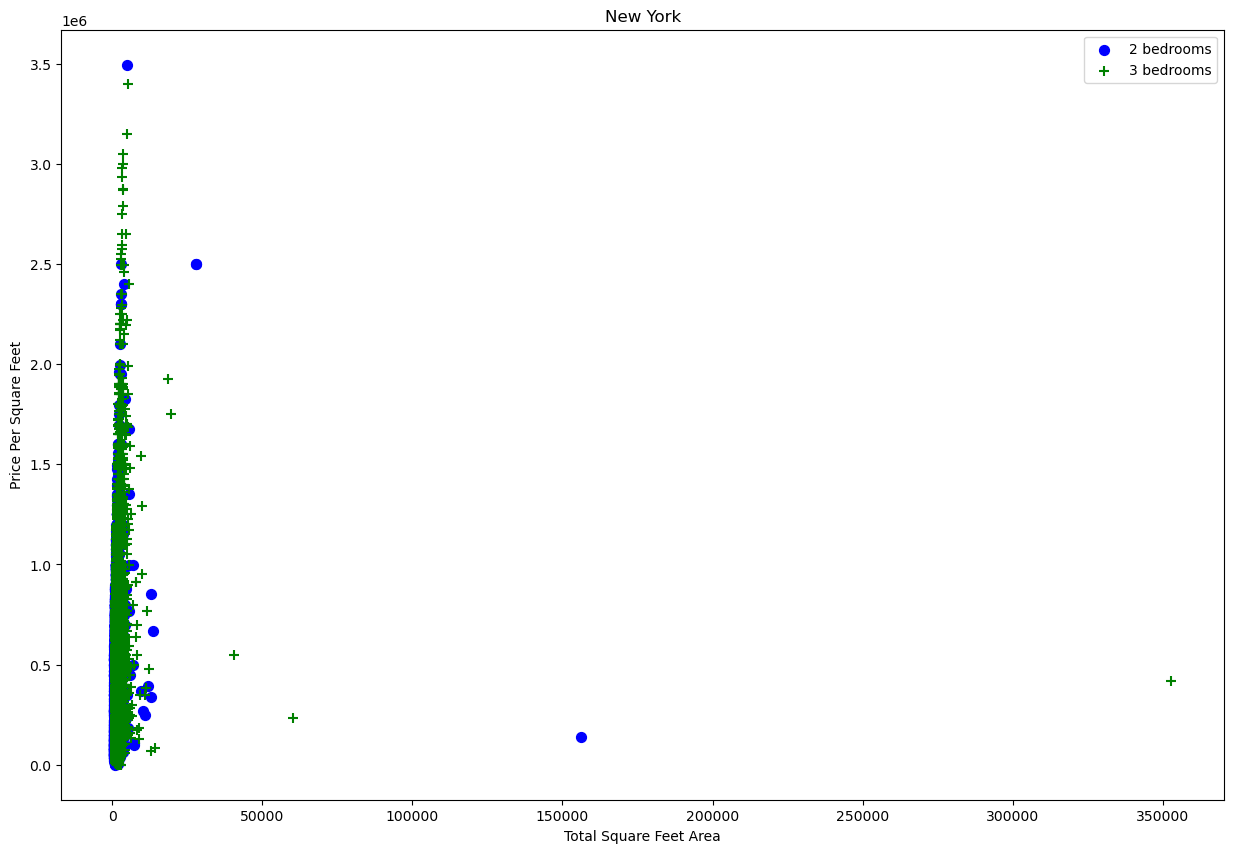

In [35]:
plot_scatter_chart(df6, 'New York')

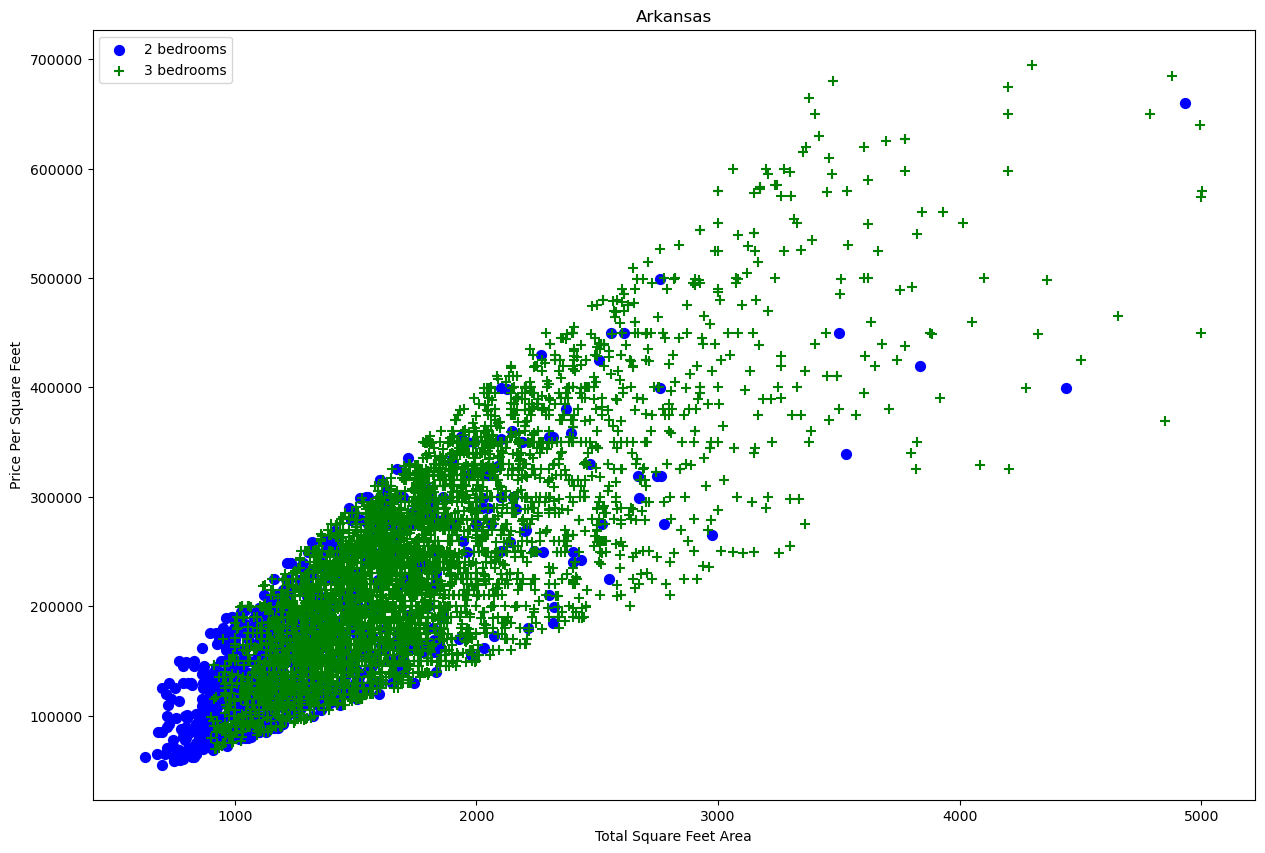

In [36]:
plot_scatter_chart(df6, 'Arkansas')

In [37]:
# Remove bedroom outliers (same state, but 2 bed price is higher than 3 bed, etc.)
def remove_bed_outliers_by_number(df):
    exclude_indices = np.array([])
    for state, state_df in df.groupby('state'):
        bed_stats = {}
        for bed, bed_df in state_df.groupby('bed'):
            bed_stats[bed] = {
                'mean': np.mean(bed_df.price_per_sqft),
                'std': np.std(bed_df.price_per_sqft),
                'count': bed_df.shape[0]
            }
        for bed, bed_df in state_df.groupby('bed'):
            stats = bed_stats.get(bed-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bed_df[bed_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

df7 = remove_bed_outliers_by_number(df6)
df7.shape

(522390, 6)

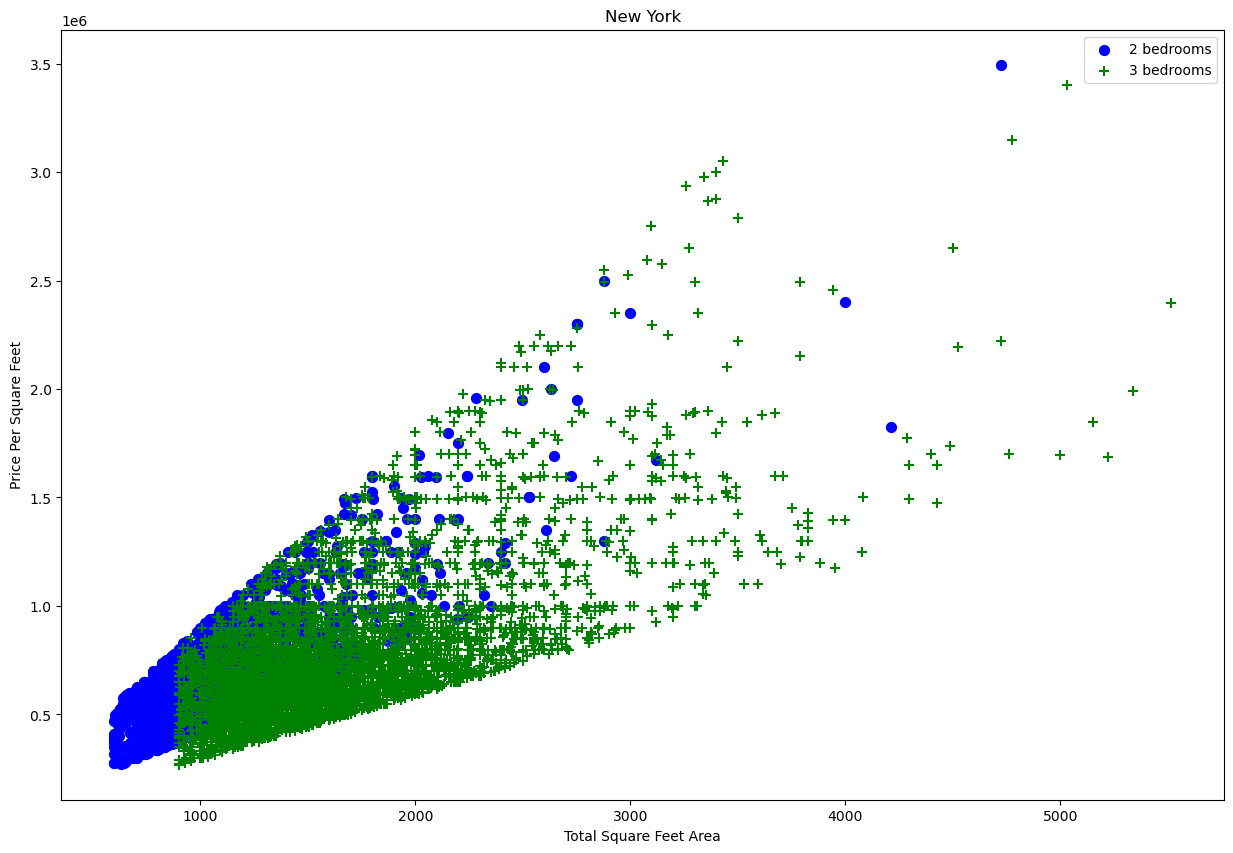

In [38]:
plot_scatter_chart(df7, 'New York')

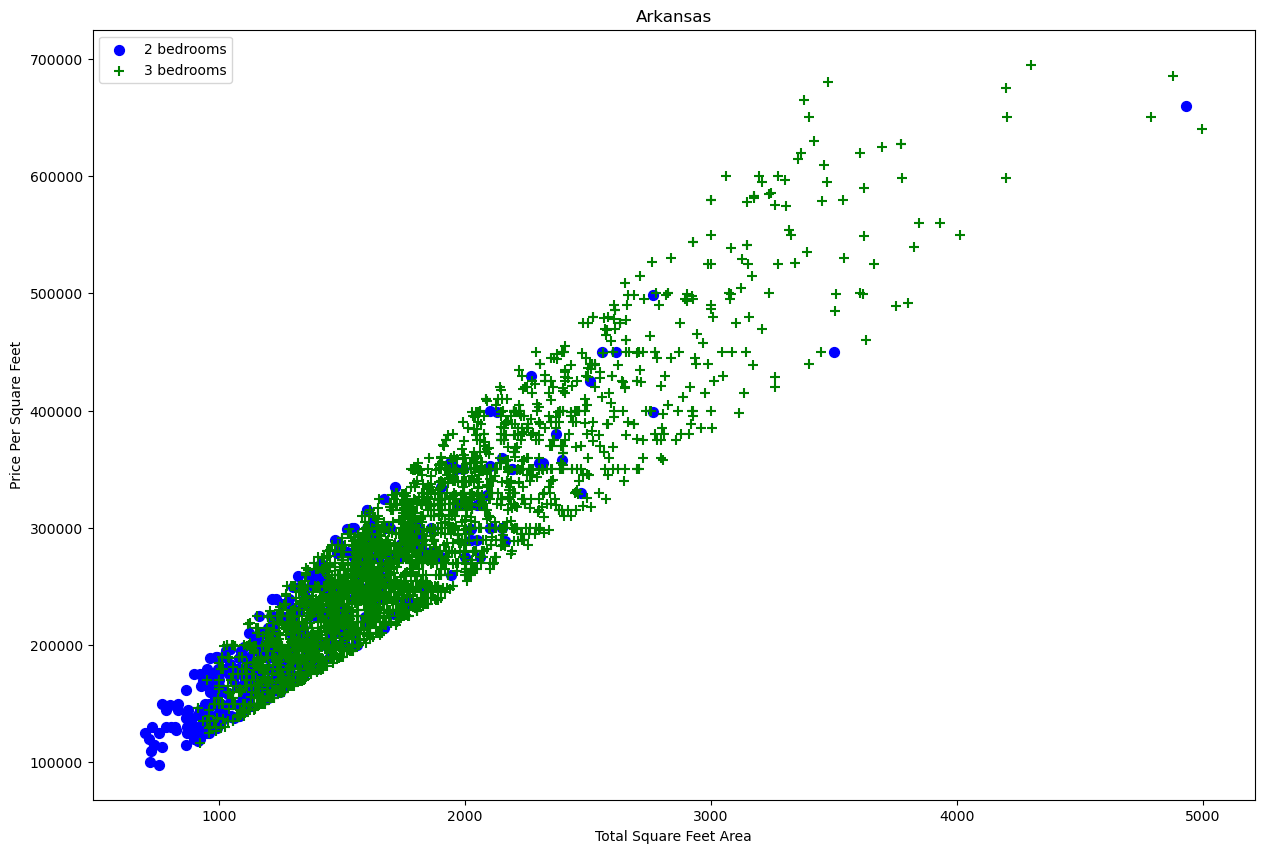

In [39]:
plot_scatter_chart(df7, 'Arkansas')

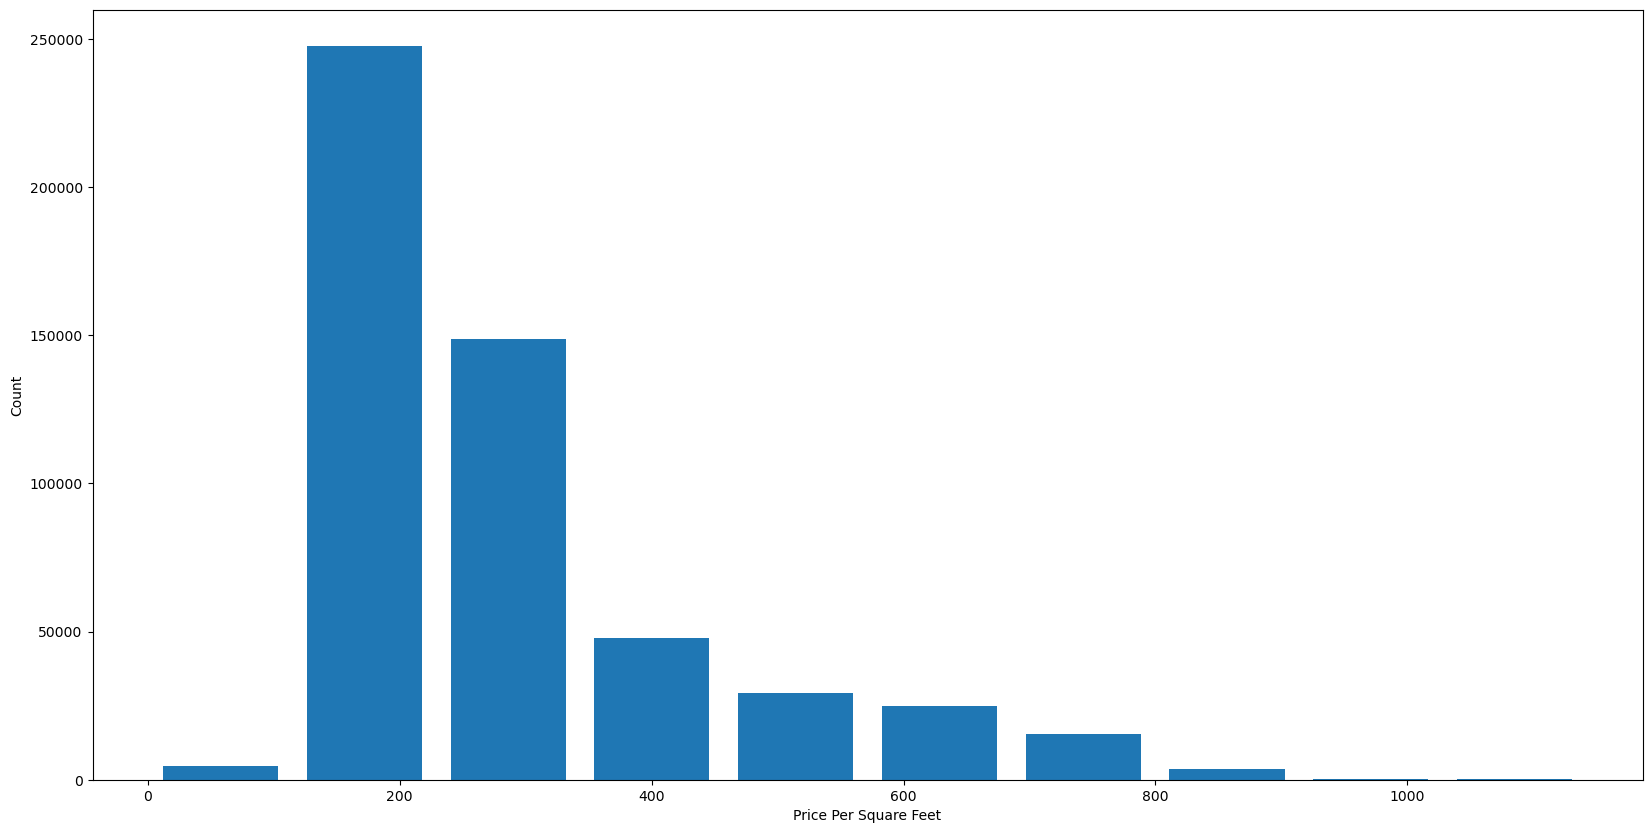

In [40]:
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df7.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")
plt.show()

## Outlier Removal: More Bathrooms than Bedrooms?

In [42]:
df7.bath.unique()

array([  4.,   2.,   3.,   1.,   5.,   6.,  17.,   7.,  14.,  10.,   8.,
        16.,   9.,  22.,  13.,  11.,  18.,  15.,  19.,  12.,  20.,  30.,
        32.,  35.,  28.,  38.,  26.,  36.,  24.,  25.,  27.,  42.,  45.,
        21., 113.])

In [43]:
# Unlikely for a house to have 2 more baths than bedrooms
df7[df7.bath>df7.bed+2]

,price,bed,bath,state,house_size,price_per_sqft
15898,685000.0,7.0,17.0,Arizona,2970.0,230.639731
61479,659950.0,9.0,14.0,Arkansas,6602.0,99.962133
63478,609900.0,4.0,8.0,Arkansas,3500.0,174.257143
64559,5800000.0,13.0,16.0,California,10712.0,541.448842
65182,2700000.0,11.0,15.0,California,6252.0,431.861804
...,...,...,...,...,...,...
1110073,819000.0,4.0,8.0,Virginia,3851.0,212.672033
1113041,590000.0,3.0,6.0,Virginia,2536.0,232.649842
1142294,799000.0,1.0,4.0,Washington,3278.0,243.746187
1156086,1085000.0,1.0,4.0,Washington,3420.0,317.251462


In [44]:
df8 = df7[df7.bath<df7.bed+2]
df8.shape

(519903, 6)

In [45]:
df8.price_per_sqft.describe()

count    519903.000000
mean        287.172140
std         155.979469
min           0.621032
25%         182.691669
50%         232.557807
75%         330.567723
max        1142.241379
Name: price_per_sqft, dtype: float64

In [46]:
df8.head()

,price,bed,bath,state,house_size,price_per_sqft
0,549000.0,4.0,4.0,Alabama,2919.0,188.078109
1,175000.0,3.0,2.0,Alabama,1234.0,141.815235
3,399900.0,4.0,3.0,Alabama,2709.0,147.619048
4,589000.0,3.0,3.0,Alabama,4108.0,143.378773
5,279000.0,3.0,2.0,Alabama,1917.0,145.539906


In [47]:
# price per sqft is unnecessary at this point
df9 = df8.drop(['price_per_sqft'],axis='columns')
df9.head()

,price,bed,bath,state,house_size
0,549000.0,4.0,4.0,Alabama,2919.0
1,175000.0,3.0,2.0,Alabama,1234.0
3,399900.0,4.0,3.0,Alabama,2709.0
4,589000.0,3.0,3.0,Alabama,4108.0
5,279000.0,3.0,2.0,Alabama,1917.0


## One Hot Encoding For Each State

In [49]:
dummies = pd.get_dummies(df9.state)
dummies.head()

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [50]:
df10 = pd.concat([df9, dummies.drop('Other', axis='columns')], axis='columns')
df10.head()

,price,bed,bath,state,house_size,Alabama,Alaska,Arizona,Arkansas,California,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,549000.0,4.0,4.0,Alabama,2919.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,175000.0,3.0,2.0,Alabama,1234.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,399900.0,4.0,3.0,Alabama,2709.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,589000.0,3.0,3.0,Alabama,4108.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,279000.0,3.0,2.0,Alabama,1917.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [51]:
df11 = df10.drop('state', axis='columns')
df11.head()

,price,bed,bath,house_size,Alabama,Alaska,Arizona,Arkansas,California,Colorado,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,549000.0,4.0,4.0,2919.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,175000.0,3.0,2.0,1234.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,399900.0,4.0,3.0,2709.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,589000.0,3.0,3.0,4108.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,279000.0,3.0,2.0,1917.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [52]:
df11.shape

(519903, 54)

## Build Linear Regression Model

In [54]:
X = df11.drop('price', axis='columns')
X.head()

,bed,bath,house_size,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,4.0,4.0,2919.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,3.0,2.0,1234.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4.0,3.0,2709.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,3.0,3.0,4108.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,3.0,2.0,1917.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [55]:
y = df11.price
y.head()

0    549000.0
1    175000.0
3    399900.0
4    589000.0
5    279000.0
Name: price, dtype: float64

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [57]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.8026779500722926

## Use K Fold cross validation to measure accuracy of our LinearRegression model

In [59]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.8069029 , 0.80851174, 0.74524019, 0.80372961, 0.79477844])

In [60]:
X.columns

Index(['bed', 'bath', 'house_size', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida',
       'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype='object')

## Test Model on Properties

In [62]:
def predict_price(state, bed, bath, sqft):    
    loc_index = np.where(X.columns==state)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = bed
    x[1] = bath
    x[2] = sqft
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [63]:
predict_price('Arkansas', 2, 2, 1000)

C:\Users\justi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


48583.86732454185

In [64]:
predict_price('Arkansas', 3, 3, 1000)

C:\Users\justi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


96987.4093843573

In [65]:
predict_price('New York', 2, 2, 1000)

C:\Users\justi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


605720.3629950716

In [66]:
predict_price('New York', 3, 3, 1000)

C:\Users\justi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


654123.905054887

## Export the Model to Pickle File

In [68]:
import pickle
with open('usa_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

## Export the Column Data to a JSON File

In [70]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))